In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")


In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint



## Developing an agent for SCML2021 (Std/Collusion)



**SCML-Standard/Collusoin brief introduction** Please refer to the first tutorial for a brief introduction about the world simulated in this game as well as pointers to more information. We will assume knowledge of at least this brief introduction in the remainder of this tutorial

Let's see the simplest possible agent (a do-nothing agent)


In [3]:
from scml.scml2020 import SCML2020Agent, SCML2021World
from scml.scml2020.agents import RandomAgent, MarketAwareDecentralizingAgent, DecentralizingAgent
ComparisonAgent = MarketAwareDecentralizingAgent

Let's start by looking at the standard/collusion tracks. These two tracks have only a minor change in the way agent score is evaluated compared with SCML2020 which means that all agents developed for SCML2020 will run with no change in SCML2021.

In [4]:
class MyDoNothing(SCML2020Agent):
    """My Agent that does nothing"""

Now, let's try to run a simulation with it

In [5]:
world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, MyDoNothing], n_steps=10), 
    construct_graphs=True,
)

### Do Nothing Agent

Let's test this agent to confirm that it is really doing nothing

In [6]:
world.run()

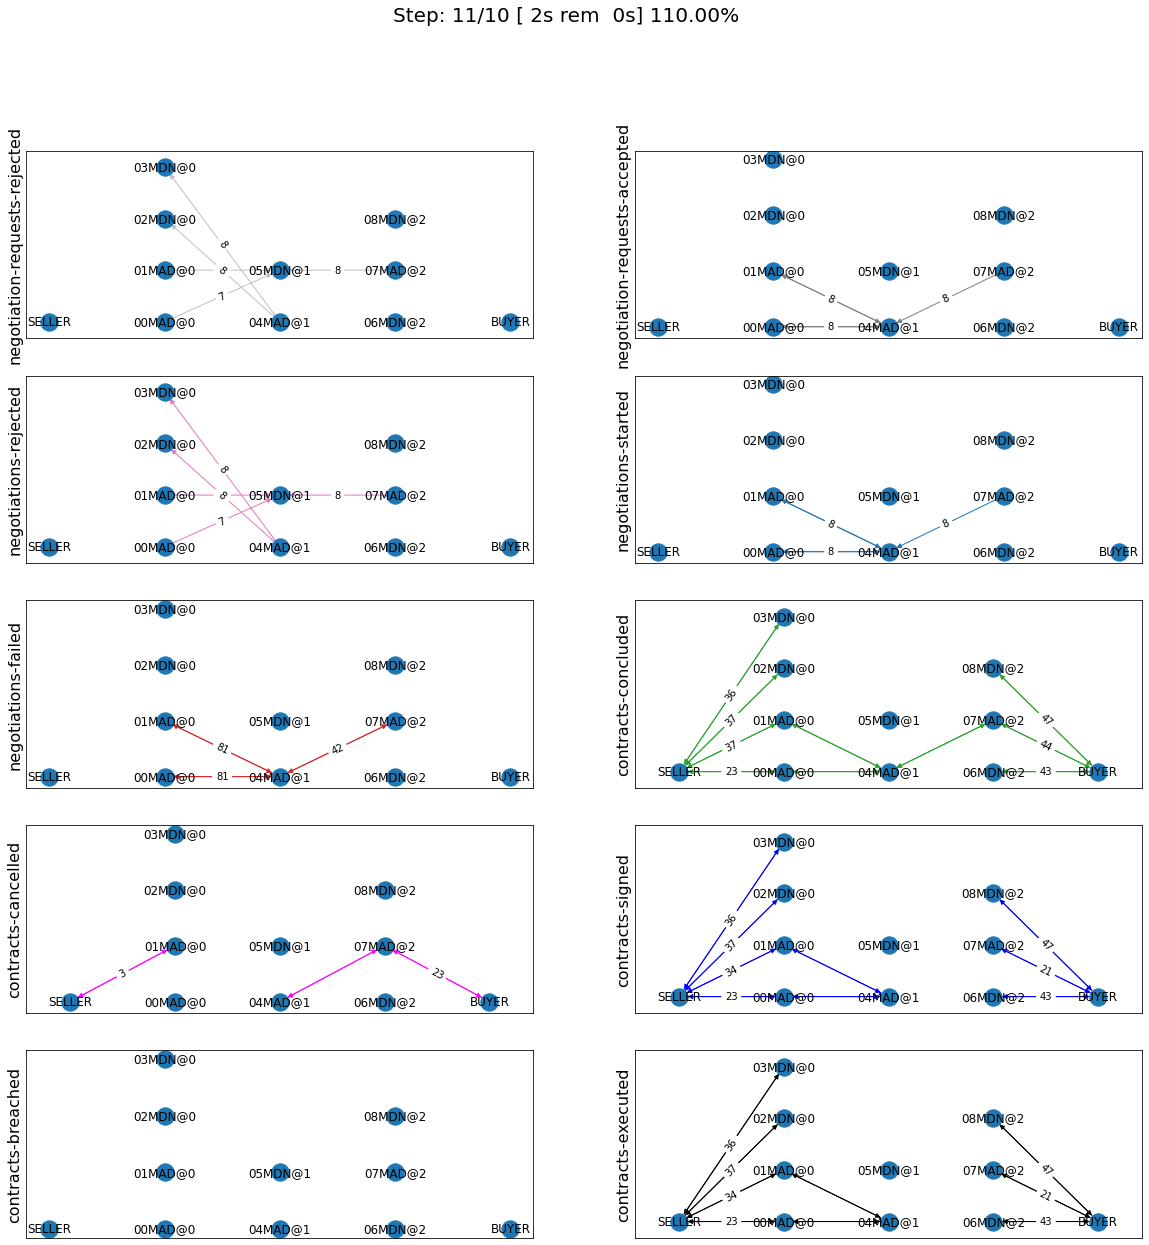

In [7]:
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

You can see that our agent did not do anything in the world. It did receive some negotiation requests which it rejected and it did not engage in any negotiations.

The full SCML game (standard and collusion leagues) combines negotiation with planning. Here the agent needs to consider long-term trading strategy, production strategy in addition to its negotiation strategy. Because negotiations can be about arbitrary times in the future and there is overlap between negotiation and contract execution with the possibility of contract cancellation, nulification, and agent bankruptcy, this is a more reaslistic, albeit much more complex, game compared with the one-shot version we just saw. 
Please refer to the game overview [here](http://www.yasserm.com/scml/overview.pdf) and the full game description [here](http://www.yasserm.com/scml/scml2021.pdf).

#### Your AWI

As described in the [previous tutorial](http://www.yasserm.com/scml/scml2020docs/tutorials/01.run_scml2020.html), your agent can sense and act in the simulation by accessing methods and properties of its AWI which is accessible at any time as:

```python
self.awi
```

You can see all of these methods and properties specific for the **OneShotAWI** and its descendents [here](http://www.yasserm.com/scml/scml2020docs/api/scml.scml2020.AWI.html). 

### Agent Anatomy

For an agent to be successul in the SCML world, it needs to buy input materials through negotiation, manufacture them, then sell output products through negotiation. In this tutorial we structure our agent as a combination of three main strategies/components:

1. **Trading Strategy**: Deciding the quantity (and price) to buy and sell at every time-step. This component can employ two subcomponents: 
  - a pre-negotiation component that decides the quantities/prices to negotaite about based on prediction of future market behavior (**trade prediction strategy**) and partner behavior (**partner beahvior prediction strategy**)
  -  a post-negotiation component that decides what agreements to sign as contracts (**signing strategy**).
2. **Negotiation Control Strategy**: This component is responsible for proactively request negotiations, responding to negotiation requests and actually conducting concurrent negotaitions. This component can further be divided into two subcomponents:
  - a pre negotiation component that decides which negotiations to accept and which to engage in (**negotiation manager**)
  - The **negotiation algorithm** used to carry out the negotiations decided by the negotiation manger. 
3. **Production Strategy**: Decides what to produce at every time-step.

You are free to organize your agent in a different way but - for the purposes of this tutorial - we will stick with this organization. 

The SCML platform provides several components that can be used to implement each of these strategies.

#### Strategies
SCML uses collaborative inheritance for composing agents by combining components implement the strategies mentioned above.

Each one of those components can implement any of the methods/callbacks provided in the SCMLAgent class and use the AWI to do so as a representative of the agent. All of them call the `super` version of any method they override to make sure that all othe components get executed.

Components also reveal some useful members to other components and the main agent either as data-members, methods, or properties.  Let's see an example



In [8]:
from IPython.display import HTML
HTML('<img src="anatomy.png">')

In [9]:
import scml
print(scml.scml2020.components.TradingStrategy.__doc__)

Base class for all trading strategies.

    Provides:
        - `inputs_needed` (np.ndarray):  How many items of the input product do
          I need to buy at every time step (n_steps vector).
          This should be read **but not updated** by the `NegotiationManager`.
        - `outputs_needed` (np.ndarray):  How many items of the output product
          do I need to sell at every time step (n_steps vector).
          This should be read **but not updated** by the `NegotiationManager`.
        - `inputs_secured` (np.ndarray):  How many items of the input product I
          already contracted to buy (n_steps vector) [out of `input_needed`].
          This can be read **but not updated** by the `NegotiationManager`.
        - `outputs_secured` (np.ndarray):  How many units of the output product
          I already contracted to sell (n_steps vector) [out of `outputs_secured`]
          This can be read **but not updated** by the `NegotiationManager`.

    Hooks Into:
        - `in

The docstring above describes the six possible sections in each component's docstring which define how is it to be constructed (attributes), what it provides to other components (provides), what it assumes about the agent (requires), what abstract methods must be overriden by any subclass of it (abstract), which callbacks of the agent does it hook-into while allowing other components to run and which does it completely override (preventing components after it in the MRO from running).

**To successfully use components to construct your agent, you need to remember to always call the `super` version of every method you overrided in your agent class to allow all components to run except if you want to completey override the behavior of all components that use this callback.**. As a rule of thump, callbacks that start with "on_", "init", and "step" should call super, the rest should not.  For a clear explanation of the use of `super` refer to [Hettinger's post](https://rhettinger.wordpress.com/2011/05/26/super-considered-super/).

#### Production Strategy

Let's start with what may be the simplest of the aforementioned components: the production strategy. What should an agent produce? There are three main limitations on the answer to this question:

1. Production capacity which is controlled by the number of lines the agent has

    > self.awi.n_lines
    
2. The available quantity of the input material

    > self.awi.state.inventory(self.awi.my_input_product)

3. The *needed* quantity of outputs. That depends on how many sell contracts the agent already have (you may also consider future sell contracts that it expects to have).

The platform provides three basic strategies for production: SupplyDriven producing based on buy-contracts, DemandDriven producing based on sell-contracts and ContracDriven producing based on both.

Let's add a demand-driven strategy to our agent. This means that our agent will only produce based on the contracts it actually signs. 




In [10]:
from scml.scml2020.components.production import DemandDrivenProductionStrategy, ProductionStrategy
class MyAgent(DemandDrivenProductionStrategy):
    """My agent"""

As you can see, using this strategy and all other components provided by the SCML platform amounts to just inheriting from it. 
You have to remember when using any of these strategies to call `super().f` whenever you implement any of the methods in `SCML2020Agent` in your agent to allow the components you are using to do their thing.

It is instructive to see how does this strategy work. This is its complete code (with type-hints and the docstring removed):

In [11]:
class DemandDrivenProductionStrategy(ProductionStrategy):
    def on_contracts_finalized(self, signed, cancelled, rejectors):
        super().on_contracts_finalized(signed, cancelled, rejectors)
        for contract in signed:
            is_seller = contract.annotation["seller"] == self.id
            # do nothing if this is not a sell contract
            if not is_seller:
                continue
            step = contract.agreement["time"]
            # find the earliest time I can do anything about this contract
            earliest_production = self.awi.current_step
            if step > self.awi.n_steps - 1 or step < earliest_production:
                continue
            # Schedule production before the delivery time
            output_product = contract.annotation["product"]
            input_product = output_product - 1
            steps, _ = self.awi.schedule_production(
                process=input_product,
                repeats=contract.agreement["quantity"],
                step=(earliest_production, step - 1),
                line=-1,
                partial_ok=True,
            )
            # set the schedule_range which is provided for other components 
            self.schedule_range[contract.id] = (
                min(steps) if len(steps) > 0 else -1,
                max(steps) if len(steps) > 0 else -1,
                is_seller,
            )
            # that is all folks


This component works by implementing both `confirm_production` and `on_contracts_finalized`. 

- The main work happens in `on_contracts_finalized`. For each signed contract, the agent schedules as much production as possible to produce the required quantity before the time it is needed at.
- `confirm_production` simply confirms everything because it assumes that the agent already scheduled correctly. Notice that despite not needing to get the output of the call of `super`, it is already called to allow other components overriding this method to work properly.

Now let's test our agent with its new production strategy. 

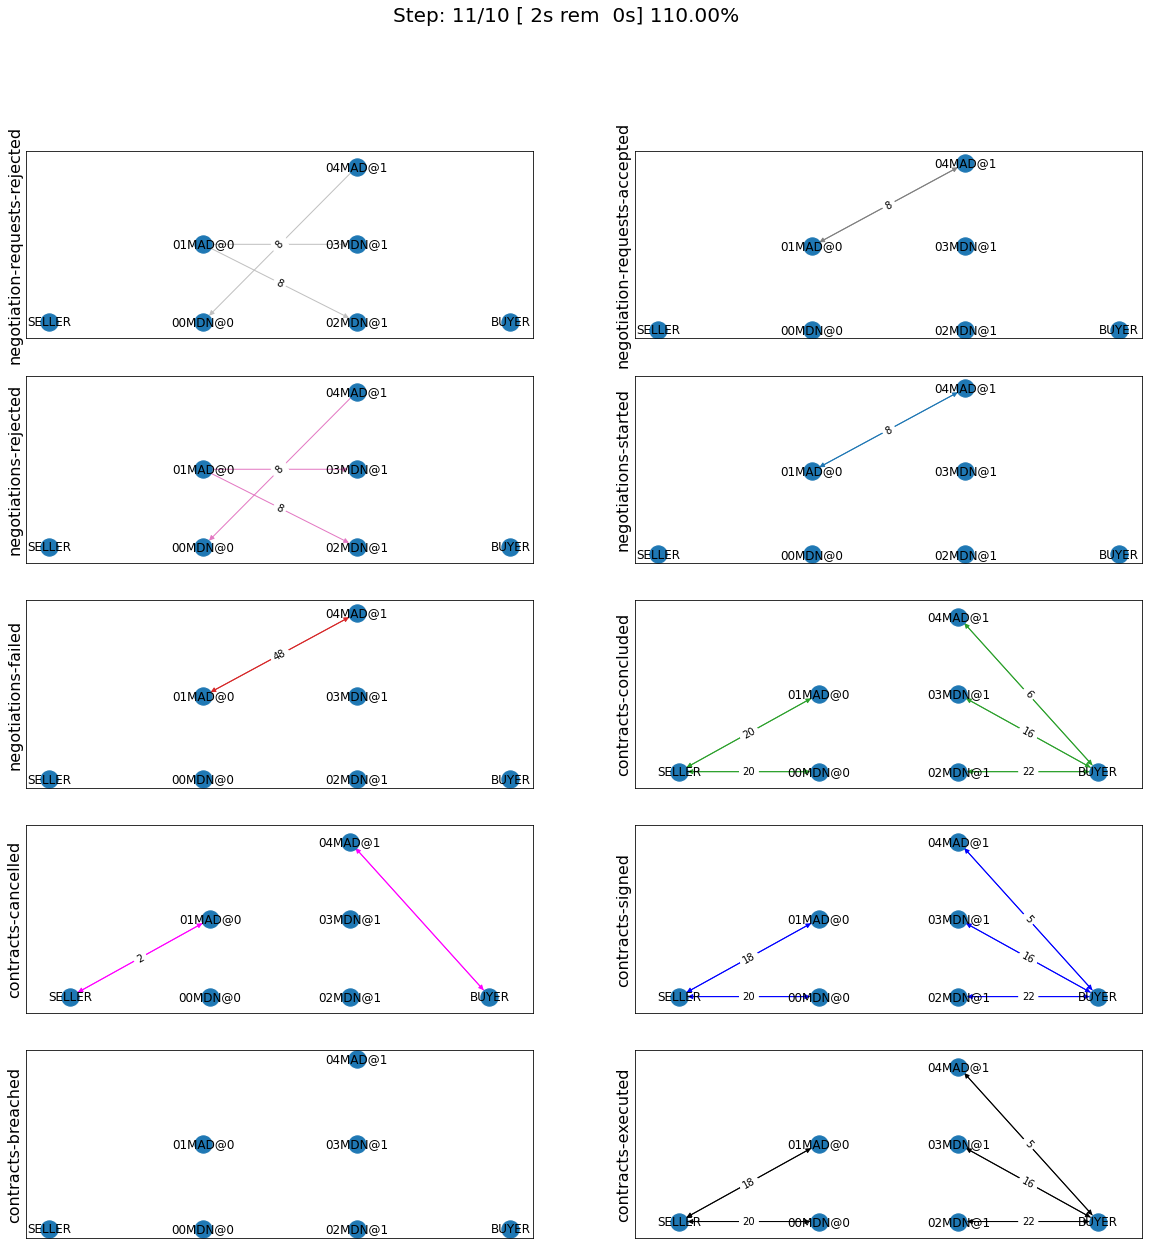

In [12]:
world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, MyDoNothing], n_steps=10), 
    construct_graphs=True,
)
world.run()
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

As expected nothing happens. Our agent is still outside the market because it does not negotiate. We need to add the other two strategies (trading and negotiation control strategies) to get it going.

#### Trading Strategy

The second component of our agent, we will implement is the trading strategy. 

Trading strategies provide the following four data-members to the agent which can be used by other components:

- inputs_needed (np.ndarray):  How many items of the input product do I need at every time step (n_steps vector)
- outputs_needed (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_secured (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_needed (np.ndarray):  How many units of the output product I have already secured per step (n_steps vector)

There are two built-in trading strategies provided: 

1. `NoTradingStrategy` Simply sign any contracts that can in principle be satisifed given the production capacity (i.e. n. lines) of the factory. Other than that there is no strategy. This strategy is not expected to work well but is useful as a baseline.
2. `PredictionBasedTradingStrategy` This strategy use a trade prediction strategy internally to predict how many inputs are expected to be available and how many outputs are expected to be sold by the agent at every time-step. Given these two quantities, it maintains the amounts of inputs/outputs that it needs. It then employs a controller to manage negotiations and update the amounts secured.

Let's use the `PredictionBasedTradingStrategy` for our agent.

In [13]:
from scml.scml2020.components.production import DemandDrivenProductionStrategy
from scml.scml2020.components.trading import PredictionBasedTradingStrategy
from scml.scml2020.components.prediction import MarketAwareTradePredictionStrategy
class MyAgent(MarketAwareTradePredictionStrategy, PredictionBasedTradingStrategy, DemandDrivenProductionStrategy, SCML2020Agent):
    """My agent"""

100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


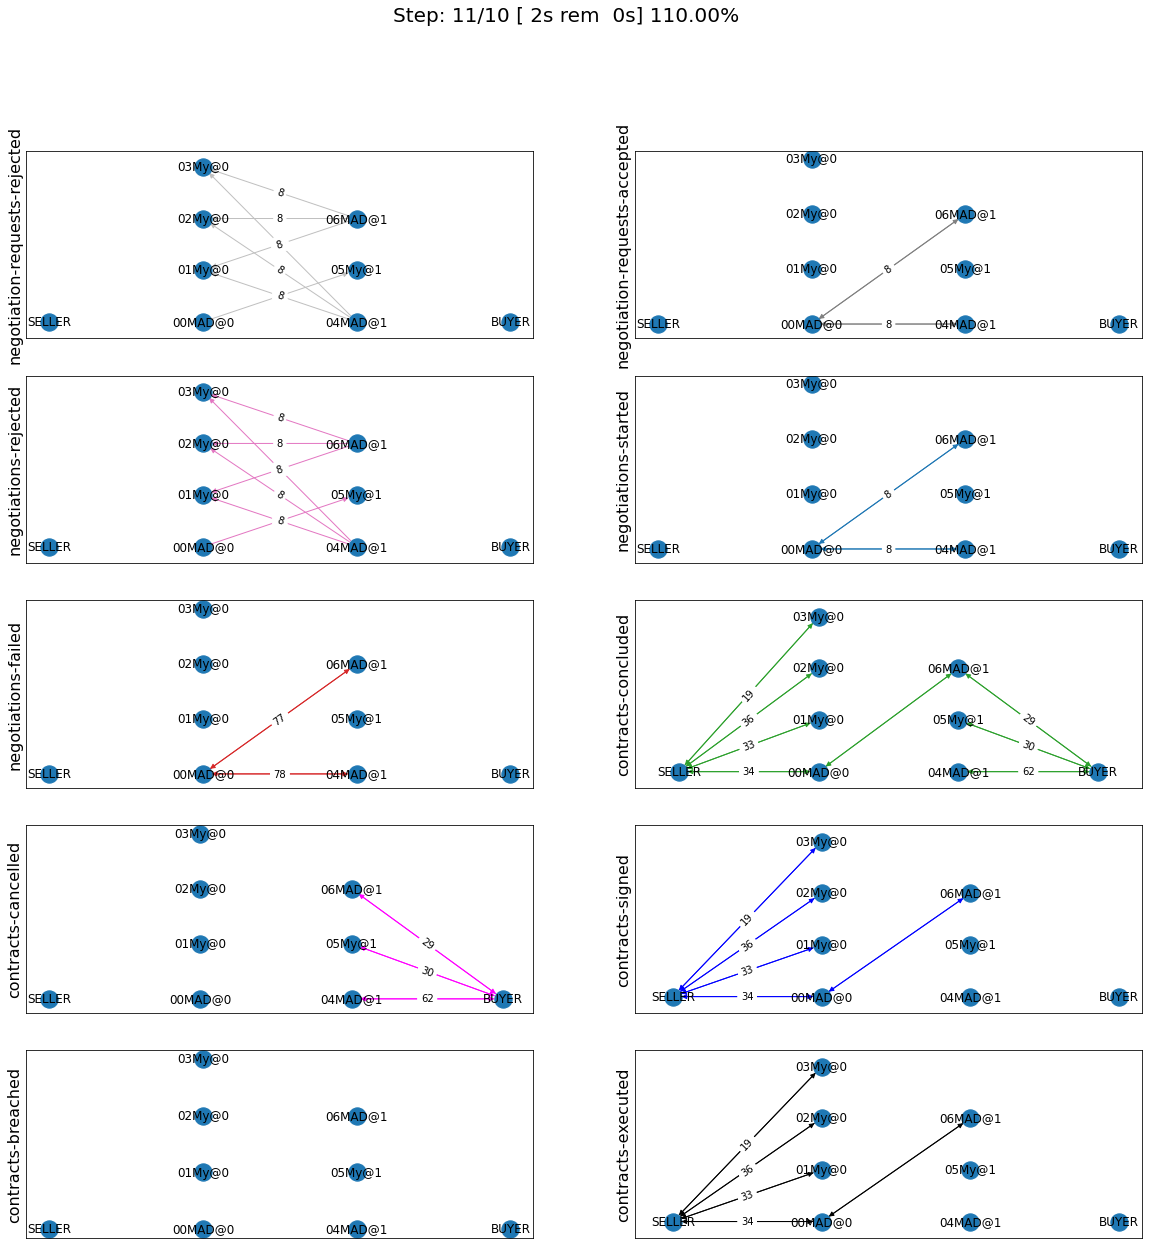

In [14]:
world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, MyAgent], n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

The last piece of the buzzle to complete our agent is to add a negotiation control strategy. We will start by reusing one of the existing strategies then develop our own.

#### Negotiation Control Strategy
Let's first try to just reuse one of the existing negotiation strategies to see how it works.


In [15]:
from scml.scml2020.components.negotiation import IndependentNegotiationsManager
class MyAgent(IndependentNegotiationsManager, PredictionBasedTradingStrategy, DemandDrivenProductionStrategy, SCML2020Agent):
    pass

In [16]:
world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, MyAgent], n_steps=10), 
    construct_graphs=True
)
try:
    world.run()
except ValueError as e:
    print(e)

You must implement target_quantity


What the system is telling us is that we forgot to implement the method `targe_quantity` . Consulting the documentation we find that we must implement two methods to use any negotiation control strategy:

1. `target_quantity` which gives the quantity that the negotiators should targe to achieve for any given time step (selling and buying)
2. `acceptable_unit_price` The maximum acceptable unit price for buying and the minimum acceptable unit price for selling

Moreover, the independent negotiation strategy requires us to implement a utility function that should work for any negotiation. 

Let's add a simple implementation of both

In [17]:
from negmas import LinearUtilityFunction
class MyAgent(IndependentNegotiationsManager, PredictionBasedTradingStrategy
              , DemandDrivenProductionStrategy, SCML2020Agent):
    def target_quantity(self, step: int, sell: bool) -> int:
        """A fixed target quantity of half my production capacity"""
        return self.awi.n_lines // 2
        
    def acceptable_unit_price(self, step: int, sell: bool) -> int:
        """The catalog price seems OK"""
        return self.awi.catalog_prices[self.awi.my_output_product] if sell else self.awi.catalog_prices[self.awi.my_input_product]
    
    def create_ufun(self, is_seller: bool, issues=None, outcomes=None):
        """A utility function that penalizes high cost and late delivery for buying and and awards them for selling"""
        if is_seller:
            return LinearUtilityFunction((0, 0.25, 1))
        return LinearUtilityFunction((0, -0.5, -0.8))


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


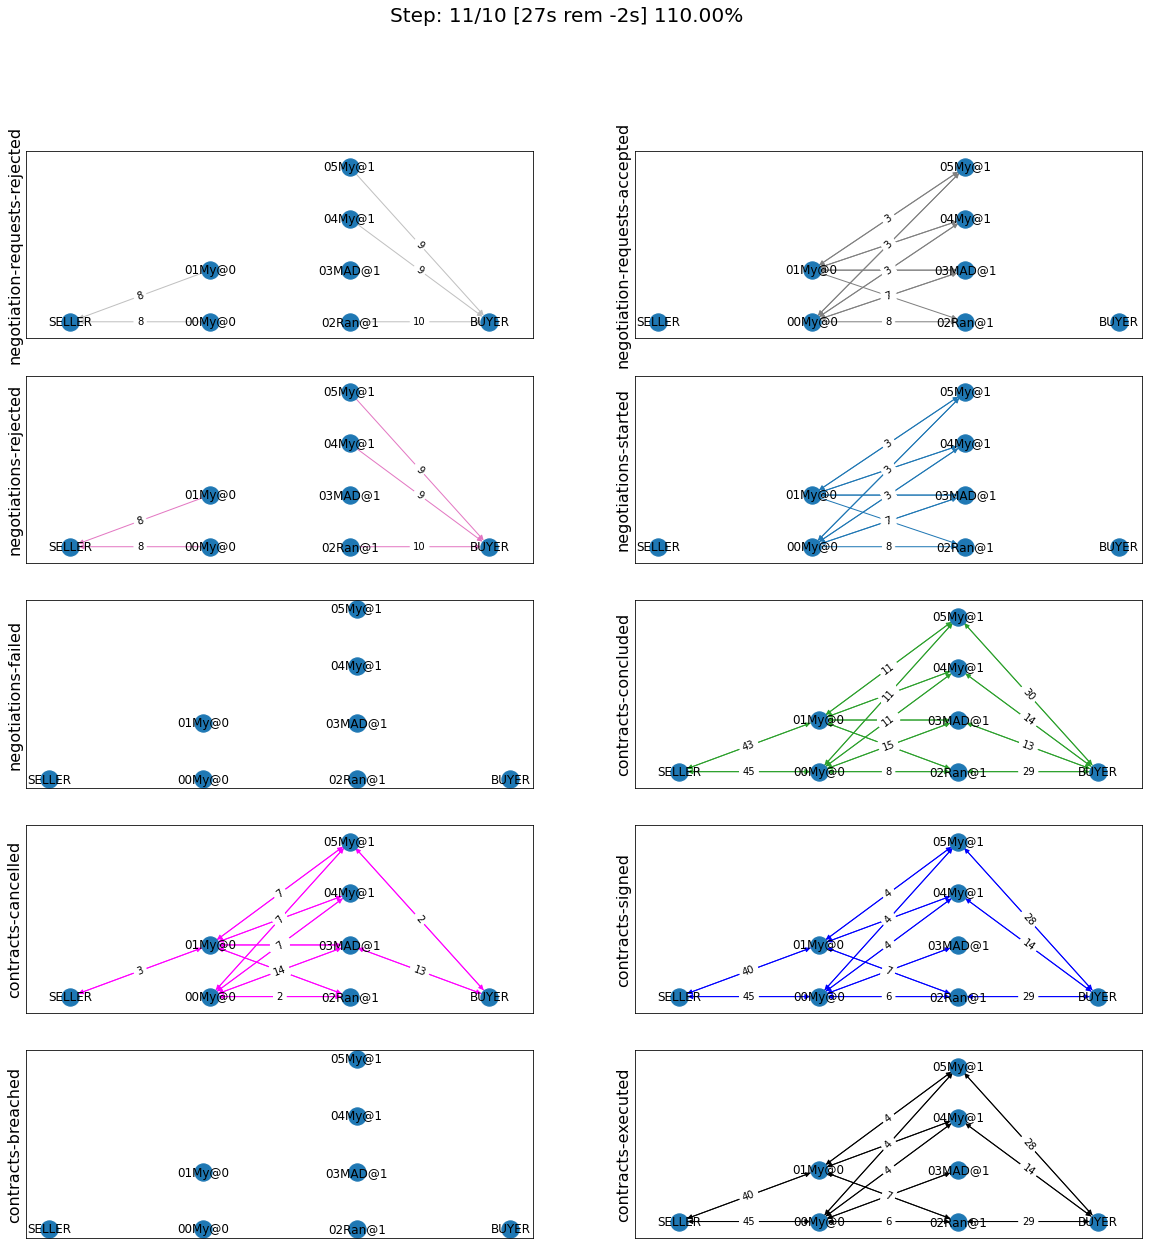

In [18]:
world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, MyAgent, RandomAgent], n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()

world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()



Our agent is now doing things in the market. It buys and sells and commits breaches. How well is it doing?
Let's see how did our agents do

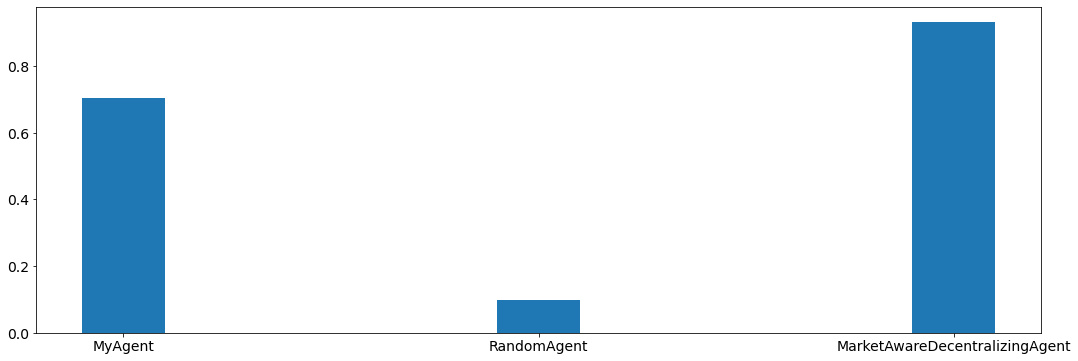

In [19]:
from collections import defaultdict
def show_agent_scores(world):
    scores = defaultdict(list)
    for aid, score in world.scores().items():
        scores[world.agents[aid].__class__.__name__.split(".")[-1]].append(score)
    scores = {k: sum(v)/len(v) for k, v in scores.items()}
    plt.bar(list(scores.keys()), list(scores.values()), width=0.2)
    plt.show()
show_agent_scores(world)

Not as good as the comparison agent :-( yet better than random :-)

But what did we expect with almost zero code. 

### Creating our own negotiation control strategy

Let's create a new negotiation control strategy and use it to replace the `IndependentNegotiationsManager` we used in our last attempt.

To start, we need to know what is expected from our component. 

We know that the trading strategy provides us with the following four data-members and we leave for it the responsibility of updating them correctly:

- inputs_needed (np.ndarray):  How many items of the input product do I need at every time step (n_steps vector)
- outputs_needed (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_secured (np.ndarray):  How many items of the output product do I need at every time step (n_steps vector)
- inputs_needed (np.ndarray):  How many units of the output product I have already secured per step (n_steps vector)

What we need from our negotiation control strategy is to find *the best* or at least *a good* way to satisfy these needs.

One way to do that is to have a `Controller` agent for selling and buying responsible of satisfying the *exact* needs at every time-step. 
NegMAS provides an easy to use controller that fits the bill called `SAOSyncController`


In [20]:
from negmas import SAOSyncController
print(SAOSyncController.__doc__)


    A controller that can manage multiple negotiators synchronously.

    Args:

        global_ufun: If true, the controller assumes that the ufun is only
                     defined globally for the complete set of negotiations

    Remarks:
        - The controller waits for an offer from each one of its negotiators before deciding what to do.
        - Loops may happen if multiple controllers of this type negotiate with each other. For example controller A
          is negotiating with B, C, while B is also negotiating with C. These loops are broken by the `SAOMechanism`
          by **forcing** some controllers to respond before they have all of the offers. In this case, `counter_all`
          will receive offers from one or more negotiators but not all of them.

    


Let's create our controller and see what do we need. The main idea here is that the controller will define a utility function for any possible outcome. It will then collect offers from all partners and responds in this way:

- If the best offer is invalid, reject everything and offer the best offer you can in every negotiation
- If the best offer is good enough (i.e. within some threshold of the best possible utility on that given negotiation) accept it
- Otherwise, send the best offer to everyone else and try to further improve this offer until near the end of the negotiation

This is a straight forward implementation of this idea

In [21]:
from scml.scml2020 import TIME, QUANTITY, UNIT_PRICE
from negmas import ResponseType, outcome_is_valid, UtilityFunction
from negmas.sao import SAOResponse
from typing import List, Dict, Optional, Tuple, Any

class ControllerUFun(UtilityFunction):
    """A utility function for the controller"""
    def __init__(self, controller=None):
        super().__init__()
        self.controller = controller

    def eval(self, offer: "Outcome"):
        return self.controller.utility(offer)

    def xml(self, issues):
        pass


class SyncController(SAOSyncController):
    """
    Will try to get the best deal which is defined as being nearest to the agent
    needs and with lowest price.

    Args:
        is_seller: Are we trying to sell (or to buy)?
        parent: The agent from which we will access `needed` and `secured` arrays
        price_weight: The importance of price in utility calculation
        utility_threshold: Accept anything with a relative utility above that
        time_threshold: Accept anything with a positive utility when we are that close
                        to the end of the negotiation
    """

    def __init__(
        self,
        *args,
        is_seller: bool,
        parent: "PredictionBasedTradingStrategy",
        price_weight=0.7,
        utility_threshold=0.9,
        time_threshold=0.9,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self._is_seller = is_seller
        self.__parent = parent
        self._time_threshold = time_threshold
        self._price_weight = price_weight
        self._utility_threshold = utility_threshold
        self.utility_function = ControllerUFun(controller=self)

    def utility(self, offer: "Outcome") -> float:
        """A simple utility function

        Remarks:
             - If the time is invalid or there is no need to get any more agreements
               at the given time, return -1000
             - Otherwise use the price-weight to calculate a linear combination of
               the price and the how much of the needs is satisfied by this contract

        """

        # get my needs and secured amounts arrays
        if self._is_seller:
            _needed, _secured = (
                self.__parent.outputs_needed,
                self.__parent.outputs_secured,
            )
        else:
            _needed, _secured = (
                self.__parent.inputs_needed,
                self.__parent.inputs_secured,
            )

        # invalide offers have no utility
        if offer is None:
            return -1000

        # offers for contracts that can never be executed have no utility
        t = offer[TIME]
        if t < self.__parent.awi.current_step or t > self.__parent.awi.n_steps - 1:
            return -1000.0

        # offers that exceed my needs have no utility (that can be improved)
        q = _needed[offer[TIME]] - (offer[QUANTITY] + _secured[t])
        if q < 0:
            return -1000.0

        # The utility of any offer is a linear combination of its price and how
        # much it satisfy my needs
        price = offer[UNIT_PRICE] if self._is_seller else -offer[UNIT_PRICE]
        return self._price_weight * price + (1 - self._price_weight) * q

    def is_valid(self, negotiator_id: str, offer: "Outcome") -> bool:
        """Is this a valid offer for that negotiation"""
        issues = self.negotiators[negotiator_id][0].nmi.issues
        return outcome_is_valid(offer, issues)

    def counter_all(
        self, offers: Dict[str, "Outcome"], states: Dict[str, "SAOState"]
    ) -> Dict[str, "SAOResponse"]:
        """Calculate a response to all offers from all negotiators (negotiator ID is the key).

        Args:
            offers: Maps negotiator IDs to offers
            states: Maps negotiator IDs to offers AT the time the offers were made.

        Remarks:
            - The response type CANNOT be WAIT.

        """

        # find the best offer
        negotiator_ids = list(offers.keys())
        utils = np.array([self.utility(o) for o in offers.values()])

        best_index = int(np.argmax(utils))
        best_utility = utils[best_index]
        best_partner = negotiator_ids[best_index]
        best_offer = offers[best_partner]

        # find my best proposal for each negotiation
        best_proposals = self.first_proposals()

        # if the best offer is still so bad just reject everything
        if best_utility < 0:
            return {
                k: SAOResponse(ResponseType.REJECT_OFFER, best_proposals[k])
                for k in offers.keys()
            }

        relative_time = min(_.relative_time for _ in states.values())

        # if this is good enough or the negotiation is about to end accept the best offer
        if (
            best_utility
            >= self._utility_threshold * self.utility(best_proposals[best_partner])
            or relative_time > self._time_threshold
        ):
            responses = {
                k: SAOResponse(
                    ResponseType.REJECT_OFFER,
                    best_offer if self.is_valid(k, best_offer) else best_proposals[k],
                )
                for k in offers.keys()
            }
            responses[best_partner] = SAOResponse(ResponseType.ACCEPT_OFFER, None)
            return responses

        # send the best offer to everyone else and try to improve it
        responses = {
            k: SAOResponse(
                ResponseType.REJECT_OFFER,
                best_offer if self.is_valid(k, best_offer) else best_proposals[k],
            )
            for k in offers.keys()
        }
        responses[best_partner] = SAOResponse(
            ResponseType.REJECT_OFFER, best_proposals[best_partner]
        )
        return responses

    def on_negotiation_end(self, negotiator_id: str, state: "MechanismState") -> None:
        """Update the secured quantities whenever a negotiation ends"""
        if state.agreement is None:
            return

        q, t = state.agreement[QUANTITY], state.agreement[TIME]
        if self._is_seller:
            self.__parent.outputs_secured[t] += q
        else:
            self.__parent.inputs_secured[t] += q



Let's understand exactly what is this controller doing. 
In NegMAS, a `Controller` is a class that manages multiple negotiations. Usually these negotiations run independently and there is no central point to collect offers from them. A special type of controller is the `SAOSyncController` which synchronizes the process of offering and responding to offers. Any `SAOSyncController` needs two things:

1. *ufun* It needs to have a utility function (inherited from `negmas.UtilityFunction` that will be used by the `SAOSyncController` to find the first proposal to offer in each negotiation.
2. *counter_all* which receives offers from all the negotiations under the control of this controller and have to respond to each one of them by either accepting it, rejecting it and countering or ending the negotiation. When loops form among controllers, the system breaks them by having *counter_all* being called with a subset of the negotiations. 

Our controller defines a utility function which is a linear combination of the price and difference between the quantity and the agent's needs at the delivery time. 

The most interesting part of the controller is the `counter_all` method. The gist of this method is finding the best offer among the set currently received. If the negotiation is about to end or this offer has a utility above some threshold it is accepted, otherwise, it is sent to all other negotiators as our new offer while sending to the partner who gave that best offer the offer with maximum utility. 


The next step is to use this controller in our negotiation strategy.

Our negotiation control strategy will work as follows:

1. It will instantiate two `SyncController` objects one for selling and one for buying.
1. It will start negotiations to satisfy the needs that it gets from the trading strategy using these controllers every simulation step.


In [22]:
class MyNegotiationManager:
    """My negotiation strategy

    Args:
        price_weight: The relative importance of price in the utility calculation.
        utility_threshold: The fraction of maximum utility above which all offers will be accepted.
        time_threshold: The fraction of the negotiation time after which any valid offers will be accepted.
        time_range: The time-range for each controller as a fraction of the number of simulation steps
    """

    def __init__(
        self,
        *args,
        price_weight=0.7,
        utility_threshold=0.9,
        time_threshold=0.9,
        time_horizon=0.1,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.index: List[int] = None
        self.time_horizon = time_horizon
        self._time_threshold = time_threshold
        self._price_weight = price_weight
        self._utility_threshold = utility_threshold
        self.controllers: Dict[bool, SyncController] = {
            False: SyncController(
                is_seller=False,
                parent=self,
                price_weight=self._price_weight,
                time_threshold=self._time_threshold,
                utility_threshold=self._utility_threshold,
            ),
            True: SyncController(
                is_seller=True,
                parent=self,
                price_weight=self._price_weight,
                time_threshold=self._time_threshold,
                utility_threshold=self._utility_threshold,
            ),
        }
        self._current_end = -1
        self._current_start = -1

    def step(self):
        super().step()
        
        # find the range of steps about which we plan to negotiate
        step = self.awi.current_step
        self._current_start = step + 1
        self._current_end = min(
            self.awi.n_steps - 1,
            self._current_start + max(1, int(self.time_horizon * self.awi.n_steps)),
        )
        if self._current_start >= self._current_end:
            return
        
        for seller, needed, secured, product in [
            (False, self.inputs_needed, self.inputs_secured, self.awi.my_input_product),
            (
                True,
                self.outputs_needed,
                self.outputs_secured,
                self.awi.my_output_product,
            ),
        ]:
            # find the maximum amount needed at any time-step in the given range
            needs = np.max(
                needed[self._current_start : self._current_end]
                - secured[self._current_start : self._current_end]
            )
            if needs < 1:
                continue
            
            # set a range of prices
            if seller:
                # for selling set a price that is at least the catalog price
                min_price = self.awi.catalog_prices[product]
                price_range = (min_price, 2 * min_price)
            else:
                # for buying sell a price that is at most the catalog price
                price_range = (0, self.awi.catalog_prices[product])
            self.awi.request_negotiations(
                not seller,
                product,
                (1, needs),
                price_range,
                time=(self._current_start, self._current_end),
                controller=self.controllers[seller],
            )

    def respond_to_negotiation_request(
        self,
        initiator: str,
        issues: List["Issue"],
        annotation: Dict[str, Any],
        mechanism: "NegotiatorMechanismInterface",
    ) -> Optional["Negotiator"]:
        # refuse to negotiate if the time-range does not intersect
        # the current range
        if not (
            issues[TIME].min_value < self._current_end
            or issues[TIME].max_value > self._current_start
        ):
            return None
        controller = self.controllers[self.id == annotation["seller"]]
        if controller is None:
            return None
        return controller.create_negotiator()


We can now replace the built-in negotiation manager in our agent with our new negotiation manager.

In [23]:
class MyNewAgent(MyNegotiationManager, PredictionBasedTradingStrategy, 
              DemandDrivenProductionStrategy, SCML2020Agent):
    pass

Let's see how did our simple new agent do:

100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


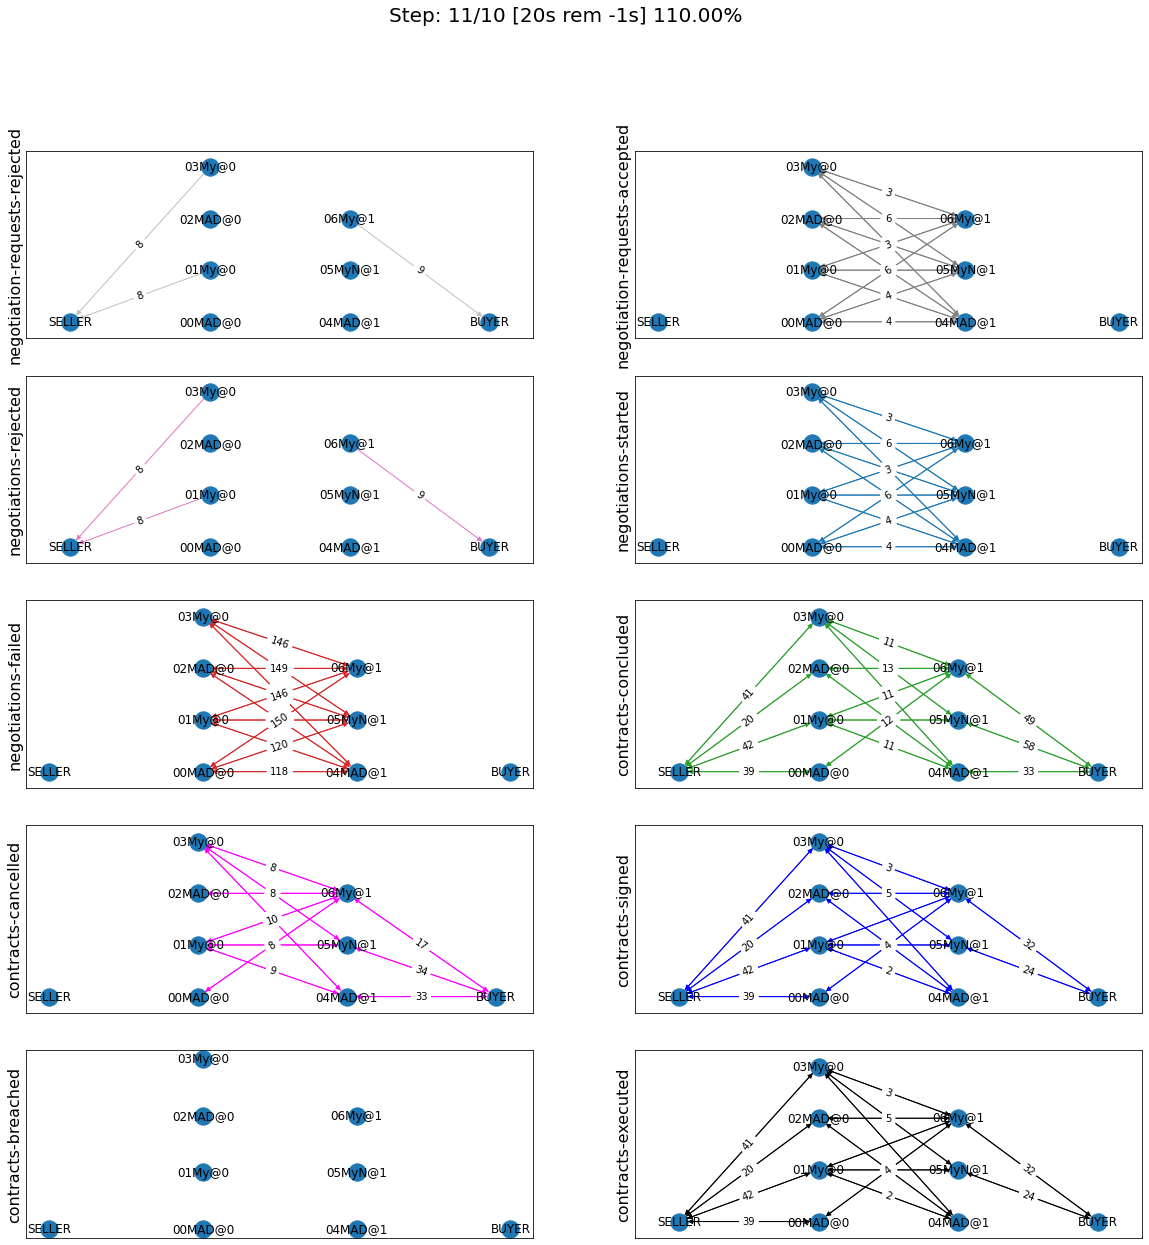

In [24]:
world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, MyAgent, MyNewAgent], n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()

world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()



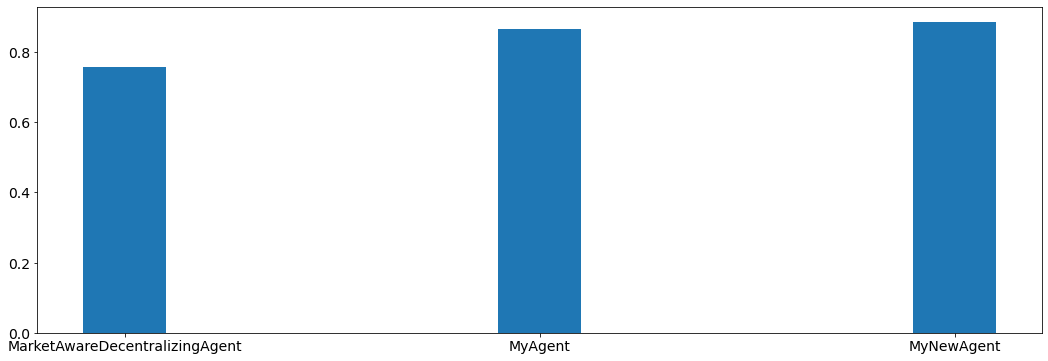

In [25]:
show_agent_scores(world)

Let's dig a little deeper and try to understand one of the reasons that `MyNewAgent` is outperforming `MyAgent`. We will focus on the average prices they get from their negotiations. 

In [26]:
from scml.scml2020 import is_system_agent

def analyze_unit_price(world, agent_type):
    """Returns the average price relative to the negotiation issues"""
    contracts = pd.DataFrame(world.saved_contracts)
    fields = ["seller_type", "buyer_type", "unit_price", "issues", "selling", "buying"]
    # Add fields indicating whether the agent_type is a seller or a buyer
    contracts["seller_type"] = contracts.seller_type.apply(lambda x: x.split(".")[-1])
    contracts["buyer_type"] = contracts.buyer_type.apply(lambda x: x.split(".")[-1])
    contracts["selling"] = contracts.seller_type == agent_type
    contracts["buying"] = contracts.buyer_type == agent_type
    # keep only contracts in which agent_type is participating
    contracts = contracts.loc[contracts.selling | contracts.buying, fields]
    # remove all exogenous contracts
    contracts = contracts.loc[contracts.issues.apply(len) > 0, fields]
    # find the minimum and maximum unit price in the negotiation issues
    min_vals = contracts.issues.apply(lambda x: x[UNIT_PRICE].min_value)
    max_vals = contracts.issues.apply(lambda x: x[UNIT_PRICE].max_value)
    # replace the unit price with its fraction of the unit-price issue range
    contracts.unit_price = (contracts.unit_price- min_vals) / (max_vals-min_vals)
    contracts = contracts.drop("issues", 1)    
    contracts = contracts.rename(columns=dict(unit_price="price"))
    # group results by whether the agent is selling/buying/both
    if len(contracts)<1:
        return ""
    print(f"{agent_type}:\n===========")
    return contracts.groupby(["selling", "buying"]).describe().round(1)


print(analyze_unit_price(world, "MyNewAgent"))
print(analyze_unit_price(world, "MyAgent"))
print(analyze_unit_price(world, "DecentralizingAgent"))

MyNewAgent:
               price                                   
               count mean  std  min  25%  50%  75%  max
selling buying                                         
False   True     6.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
MyAgent:
               price                                   
               count mean  std  min  25%  50%  75%  max
selling buying                                         
False   True    25.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
True    False   28.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
        True    22.0  0.5  0.1  0.4  0.5  0.5  0.6  0.6



We can see that the new strategy gets lower average prices when buying and higher average prices when selling. That may partially explain its relative superiority compared with `MyAgent`. It is doing a better job in this compared with the built-in `DecentralizingAgent` as well. Nevertheless, `DecentralizingAgent` is getting better results. That may have something to do with quantities relative to needs. Try analyzing this aspect to get a deeper understanding of how should your negotiation strategy manage multiple negotiations.

### Changing the negotiation strategy

The negotiation strategy used by our agent has several flows but one of them is almost fatal. When negotiating with other agents of its own type, It will most likely lead to agreements at the boundaries of the issue space that have low utility for one of the negotiators and which one is almost random. Can you see why?

Let's try to run our new agent against itself.

In [27]:
world = SCML2021World(
    **SCML2021World.generate([MyNewAgent], n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()
print(analyze_unit_price(world, "MyNewAgent"))

100%|██████████| 10/10 [00:01<00:00,  7.03it/s]

Notice how *all* agreements are on limits of the unit_price issue. If you investigate the other two issues, you will notice the same pattern. why?

Consider two of our agent negotiating together. Let's say that the buyer requested the negotiation (in its `step()` method). The relevant request code is repeated here:

```python
    if seller:
        min_price = self.awi.catalog_prices[product]
        price_range = (min_price, 2 * min_price)
    else:
        price_range = (0, self.awi.catalog_prices[product])
    self.awi.request_negotiations(
        not seller,
        product,
        (1, needs),
        price_range,
        time=(self._current_start, self._current_end),
        controller=self.controllers[seller],
    )
```

which will lead to a price range of (0, $x$) where $x$ is the catalog price of the product. The quantity will be in the range (1, $q$) where $q$ is the needs of the buyer.

What will happen is that our buyer will keep offering zero price (as this is its best price) and our seller will keep offering $x$. None of them will find this satisfactory (i.e. leading to a utility less than the `utility_threshold`) but in the last negotiation step, the agent that happens to be last will just have to accept the offer (if it has any positive utility). This means that we will get either $0$ or $x$ as the agreed upon price. 

Let's try to improve that a little bit. We will use another type of controller provided by NegMAS (for a tutorial on different controllers types available in negmas check [this](https://youtu.be/10Rjl3ikaDU) video). The `SAOMetaNegotiatorController` provides a way to use a signle negotiation strategy in multiple concurrent negotiations which seems like what we need here. We will use it with the default time-based negotiation strategy.

Another issue with our negotiation strategy is that it is slow. Because it tries to synchronize all of its negotiators and counter all offers at once, it must delay all negotiations. Moreover, our utility function has no structure known to the system (i.e. it is not linear, not a set of hyper-volumes, etc) which means that finding the best offer or finding an outcome with a given utility will depend on random sampling which is also slow. We will try to avoid these shortcomings in our improved negotiation strategy. To summarize we need the following:

1. A faster utility function with a known structure: We will use a linear ufun.
2. A faster controller that does not try to synchronize all of its negotiators: We will use an `SAOMetaNegotiatorController` for that.
3. A controller that allows us to get agreements that are not necessarily at the edges of the issue space. That is already taken care of by the `SAOMetaNegotiatorController`

Our new manager will be similar to `MyNegotiationManager` we just developed but will not need the `SyncController`. Instead of keeping two controllers only and reusing them for all negotiations, we will create a new controller for each set of negotiations we want to request. This can be done in one line by creating the controller passing it an appropriate ufun:
```python
    controller = SAOMetaNegotiatorController(ufun=LinearUtilityFunction({
        TIME: 0.0, QUANTITY: (1-x), UNIT_PRICE: x if seller else -x
    })) 
```
where $x$ is some weight between zero and one to weight price against quantity. We use a negative price weight if we are buying to reduce the price.
One issue we will face though is what to do when receiving negotiation requests? For this first trial, we will just reject all of them. This means that our agent will only engage in negotiations it starts. This is a dangerous strategy in the actual game because it will lead to many lost opportunities but it will do for exploring the design space.

In [33]:
from negmas import SAOMetaNegotiatorController

class YetAnotherNegotiationManager:
    """My new negotiation strategy

    Args:
        price_weight: The relative importance of price in the utility calculation.
        time_range: The time-range for each controller as a fraction of the number of simulation steps
    """

    def __init__( self, *args, price_weight=0.7, time_horizon=0.1, **kwargs,):
        super().__init__(*args, **kwargs)
        self.index: List[int] = None
        self.time_horizon = time_horizon
        self._price_weight = price_weight
        self._current_end = -1
        self._current_start = -1

    def step(self):
        super().step()
        
        # find the range of steps about which we plan to negotiate
        step = self.awi.current_step
        self._current_start = step + 1
        self._current_end = min(
            self.awi.n_steps - 1,
            self._current_start + max(1, int(self.time_horizon * self.awi.n_steps)),
        )
        if self._current_start >= self._current_end:
            return
        
        for seller, needed, secured, product in [
            (False, self.inputs_needed, self.inputs_secured, self.awi.my_input_product),
            ( True, self.outputs_needed, self.outputs_secured, self.awi.my_output_product),
        ]:
            # find the maximum amount needed at any time-step in the given range
            needs = np.max(
                needed[self._current_start : self._current_end]
                - secured[self._current_start : self._current_end]
            )
            if needs < 1:
                continue
            # set a range of prices
            if seller:
                # for selling set a price that is at least the catalog price
                min_price = self.awi.catalog_prices[product]
                price_range = (min_price, 2 * min_price)
                controller = SAOMetaNegotiatorController(ufun=LinearUtilityFunction(
                    (0.0, (1-self._price_weight), 0.0, self._price_weight)
                ))
            else:
                # for buying sell a price that is at most the catalog price
                price_range = (0, self.awi.catalog_prices[product])
                controller = SAOMetaNegotiatorController(ufun=LinearUtilityFunction(
                    ((1-self._price_weight), 0.0, -self._price_weight)
                ))

            self.awi.request_negotiations(
                not seller,
                product,
                (1, needs),
                price_range,
                time=(self._current_start, self._current_end),
                controller=controller,
            )

    def respond_to_negotiation_request(
        self,
        initiator: str,
        issues: List["Issue"],
        annotation: Dict[str, Any],
        mechanism: "NegotiatorMechanismInterface",
    ) -> Optional["Negotiator"]:
        return None
    
class AspirationAgent(YetAnotherNegotiationManager, PredictionBasedTradingStrategy, 
              DemandDrivenProductionStrategy, SCML2020Agent):
    pass

In [34]:
world = SCML2021World(
    **SCML2021World.generate([MyAgent, MyNewAgent, AspirationAgent], n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()

100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


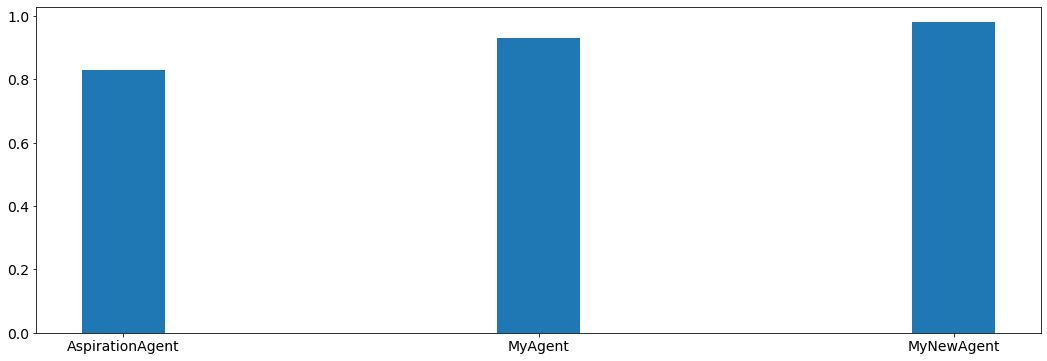

MyNewAgent:
               price                                   
               count mean  std  min  25%  50%  75%  max
selling buying                                         
False   True     4.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
True    False   56.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
AspirationAgent:
               price                                   
               count mean  std  min  25%  50%  75%  max
selling buying                                         
True    False   48.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [35]:
show_agent_scores(world)
for agent_type in ("MyNewAgent", "AspirationAgent"):
    print(analyze_unit_price(world, agent_type))

The `AspirationAgent` seems to be better than our earlier attempts in terms of score. It buys at higher prices than `MyNewAgent` and sells at lower prices, yet it manages to get agreements all over the issue space rather than being concentrated on the boundaries. It is easy to improve the `AspirationAgent` if we can find a way to respond to negotiation requests assigning new requests to the appropriate controller. We will not attempt that in this tutorial.

### Overriding an agent directly

You do not need to know what are the components used by an agent to base your design on it. Let's say that we want to base our design on `DecentralizingAgent` and we will just change the prediction strategy it uses to predict the expected supply and demand. 

This is done using a `FixedTradePredictionStrategy`. We can just create a new *trade prediction strategy* and use it in our agent. This is an example:

In [36]:
from scml.scml2020.components import MarketAwareTradePredictionStrategy
class MyPredictor(MarketAwareTradePredictionStrategy):
    def trade_prediction_init(self):
        inp = self.awi.my_input_product
        self.expected_outputs = self.awi.n_lines * np.ones(self.awi.n_steps, dtype=int)
        self.expected_inputs = self.awi.n_lines * np.ones(self.awi.n_steps, dtype=int)

class MyDecentralizingAgent(MyPredictor, DecentralizingAgent):
    pass

That was much less typing. Notice that the order of `MyPredictor` and `DecentralizingAgent` is very important becuase it is used to calculate the method calling order (MRO) in python. If you reverse them, you will not get any errors but your code will never be called.

Let's test it

In [37]:
world = SCML2021World(
    **SCML2021World.generate([AspirationAgent, ComparisonAgent, MyDecentralizingAgent]
                             , n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


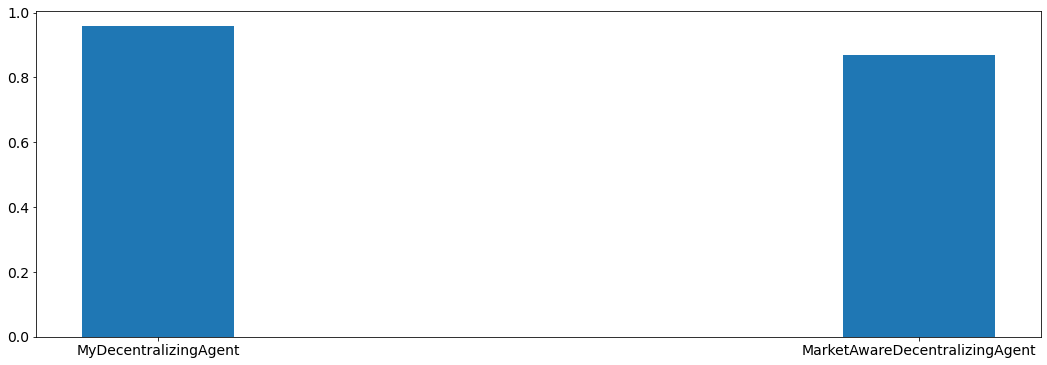

In [38]:
show_agent_scores(world)

<div class="alert alert-block alert-warning">
Note that all the comparisons done in this tutorial are based on <b>a single world simulation of 10 steps</b>. In the actual competition we will have thousands of simulations with steps ranging from 50 to 200 so the results in this tutorial are not indicative.</div>


### An agent from scratch

For completeness, let's build a nontrivial (yet not very good) agent from scratch without using any built-in components.  The main goal of this part of the tutorial is to get you thinking about the core negotiation related problems inherent in the SCML world.

Our agent will be mostly reactive. It will depend on other agents to start negotiations with it.

The main idea behind this agent is very simple:

1. It will keep track of the average price of its input and output products. 
    * This is done by initializing the prices in the `init` function to catalog prices
    
    ```python
        self.prices = [
            self.awi.catalog_prices[self.awi.my_input_product],
            self.awi.catalog_prices[self.awi.my_output_product],
        ]
        self.quantities = [0, 0]
    ```
    
    then updating it whenever a contract is finalized using the running mean formula:
    
    ```python
        is_seller = contract.annotation["seller"] == self.id
        oldq = self.quantities[is_seller]
        self.quantities[is_seller] += q
        self.prices[is_seller] = (
            oldq * self.prices[is_seller] + p * q
        ) / self.quantities[is_seller]
    ```
    
2.  The agent will respond to negotiations by creating a time-strategy `AspirationNegotiator` with the appropriate ufun. It will use a very simple ufun which is linear in the price setting all prices under the currently tracked prices (for selling) and over it (for buying) to a negative utility value. This is done by a `create_ufun` method:

```python
def create_ufun(self, is_seller, prange):
    if is_seller:
        return MappingUtilityFunction(
            lambda x: -1000 if x[UNIT_PRICE] < self.prices[1] else x[UNIT_PRICE],
            reserved_value=0.0,
        )
    return MappingUtilityFunction(
        lambda x: -1000
        if x[UNIT_PRICE] > self.prices[0]
        else prange[1] - x[UNIT_PRICE],
        reserved_value=0.0,
    )
```

3. The agent knows that it never negotiates on bad contracts so it signs everything in `sign_all_contracts` and it uses a supply driven strategy by producing any input products available in its `step()` method:

```python
    commands = NO_COMMAND * np.ones(self.awi.n_lines, dtype=int)
    inputs = min(self.awi.state.inventory[self.awi.my_input_product], len(commands))
    commands[:inputs] = self.awi.my_input_product
    self.awi.set_commands(commands)
```


In [39]:
from negmas import MappingUtilityFunction, AspirationNegotiator
from scml.scml2020 import NO_COMMAND

class FromScratchAgent(SCML2020Agent):
    def init(self):
        self.prices = [
            self.awi.catalog_prices[self.awi.my_input_product],
            self.awi.catalog_prices[self.awi.my_output_product],
        ]
        self.quantities = [1, 1]

    def step(self):
        super().step()
        # update prices based on market information if available
        tp = self.awi.trading_prices
        if tp is None:
            self.prices = [
                self.awi.catalog_prices[self.awi.my_input_product],
                self.awi.catalog_prices[self.awi.my_output_product],
            ]
        else:
            self.prices = [
                self.awi.trading_prices[self.awi.my_input_product],
                self.awi.trading_prices[self.awi.my_output_product],
            ]
        
        # produce everything I can
        commands = NO_COMMAND * np.ones(self.awi.n_lines, dtype=int)
        inputs = min(self.awi.state.inventory[self.awi.my_input_product], len(commands))
        commands[:inputs] = self.awi.my_input_product
        self.awi.set_commands(commands)

    def respond_to_negotiation_request(
        self,
        initiator: str,
        issues: List["Issue"],
        annotation: Dict[str, Any],
        mechanism: "NegotiatorMechanismInterface",
    ) -> Optional["Negotiator"]:
        is_seller = annotation["seller"] == self.id
        # do not engage in negotiations that obviouly have bad prices for me
        if is_seller and issues[UNIT_PRICE].max_value < self.prices[is_seller]:
            return None
        if not is_seller and issues[UNIT_PRICE].min_value > self.prices[is_seller]:
            return None
        ufun = self.create_ufun(
            is_seller, (issues[UNIT_PRICE].min_value, issues[UNIT_PRICE].max_value),
        )
        return AspirationNegotiator(ufun=ufun)

    def sign_all_contracts(self, contracts: List["Contract"]) -> List[Optional[str]]:
        """Called to ask you to sign all contracts that were concluded in
        one step (day)"""
        return [self.id] * len(contracts)

    def on_contracts_finalized(
        self,
        signed: List["Contract"],
        cancelled: List["Contract"],
        rejectors: List[List[str]],
    ) -> None:
        awi: AWI = self.awi
        for contract in signed:
            t, p, q = (
                contract.agreement["time"],
                contract.agreement["unit_price"],
                contract.agreement["quantity"],
            )
            is_seller = contract.annotation["seller"] == self.id
            oldq = self.quantities[is_seller]
            self.quantities[is_seller] += q
            self.prices[is_seller] = (
                oldq * self.prices[is_seller] + p * q
            ) / self.quantities[is_seller]
            
    def create_ufun(self, is_seller, prange):
        if is_seller:
            return MappingUtilityFunction(
                lambda x: -1000 if x[UNIT_PRICE] < self.prices[1] else x[UNIT_PRICE],
                reserved_value=0.0,
            )
        return MappingUtilityFunction(
            lambda x: -1000
            if x[UNIT_PRICE] > self.prices[0]
            else prange[1] - x[UNIT_PRICE],
            reserved_value=0.0,
        )



100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


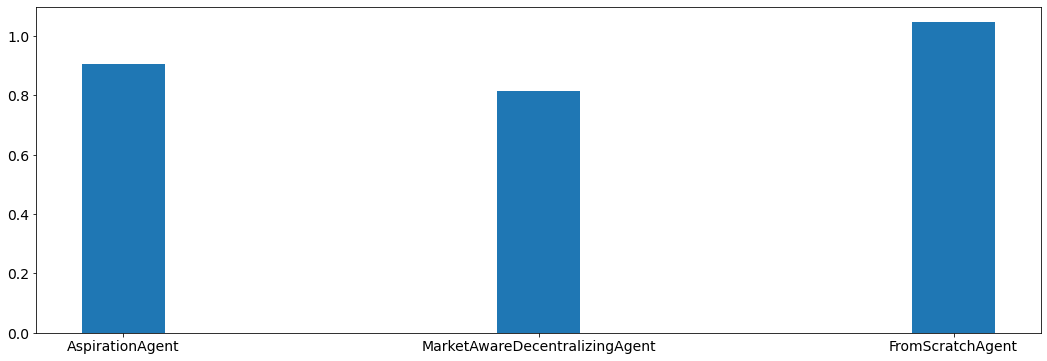

In [40]:
world = SCML2021World(
    **SCML2021World.generate([AspirationAgent, ComparisonAgent, FromScratchAgent]
                             , n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()
show_agent_scores(world)

This agent will only make profit if by-chance it could get sell contracts following buy contracts allowing it to produce. 

We can improve the performance of the agent by being slightly more proactive.
Given its reactive strategy, the agent can assume that it can get buy and sell contracts at good prices. The remaining step is to negotiate to sell/buy whenever it gets a signed buy/sell contract. This is done in the `on_contracts_finalized` callback as follows:

* Find the agreement conditions:

```python
    t, p, q = (
        contract.agreement["time"],
        contract.agreement["unit_price"],
        contract.agreement["quantity"],
    )
```

* When the agent gets a contract to sell, it needs to buy the same amount of the input material before the deliver time and when it gets a contract to buy, it needs to sell the same amount after that. A special cases need to be taken into account though:
    * If the contract was the result of a negotiation started by the agent, it already has the corresponding sell/buy contract so it should ignore it. This can be tested easily
    
```python
    if contract.annotation["caller"] == self.id:
        ...
```
   
Here is the improved version:

In [41]:
class ProactiveFromScratch(FromScratchAgent):
     def on_contracts_finalized(
        self,
        signed: List["Contract"],
        cancelled: List["Contract"],
        rejectors: List[List[str]],
    ) -> None:
        super().on_contracts_finalized(signed, cancelled, rejectors)
        awi: AWI = self.awi
        for contract in signed:
            t, p, q = (
                contract.agreement["time"],
                contract.agreement["unit_price"],
                contract.agreement["quantity"],
            )
            is_seller = contract.annotation["seller"] == self.id            
            if contract.annotation["caller"] == self.id:
                continue
            product = awi.my_output_product if is_seller else awi.my_input_product
            partners = awi.my_consumers if is_seller else awi.my_suppliers
            qrange = (1, q)
            prange = self.prices[not is_seller]
            trange = (awi.current_step, t) if is_seller else (t, awi.n_steps - 1)
            negotiators = [
                AspirationNegotiator(ufun=self.create_ufun(is_seller, prange))
                for _ in partners
            ]
            awi.request_negotiations(
                is_buy=is_seller,
                product=product,
                quantity=qrange,
                unit_price=prange,
                time=trange,
                controller=None,
                negotiators=negotiators,
            )

100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


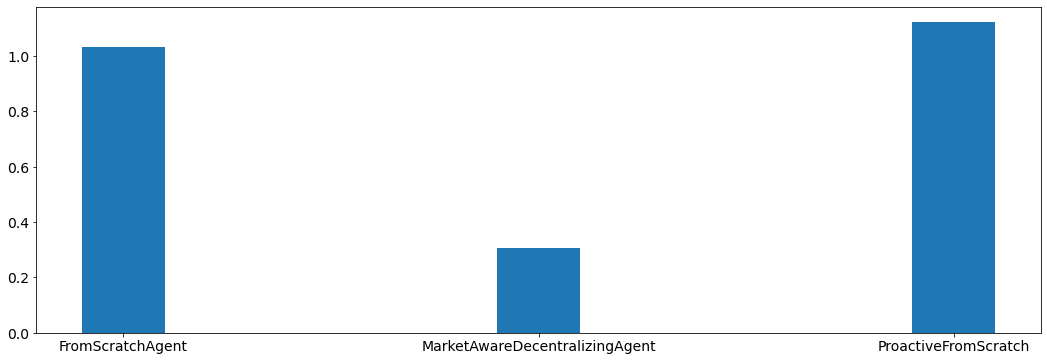

In [42]:
world = SCML2021World(
    **SCML2021World.generate([ProactiveFromScratch, ComparisonAgent, FromScratchAgent]
                             , n_steps=10), 
    construct_graphs=True
)
world.run_with_progress()
show_agent_scores(world)

### A competition

Even though all of the agents developed in this tutorial are simplistic and are only intended to show different approaches to develop your own agent, it is instructive to see how do they fair against each other.

Unfortunately, we do not support running tournaments between agents inside a notebook (because of the way Jupyter handles the `__main__` module which results in the agents not being associated with any module). To run a tournament you will need this code snippet:

```python
from scml.scml2020.utils import anac2021_std
import seaborn as sns
tournament_types = [ProactiveFromScratch, FromScratchAgent, 
                    MyAgent, MyNewAgent, AspirationAgent]
results = anac2021_std(
    competitors=tournament_types,  
    n_configs=20, # number of different configurations to generate 
    n_runs_per_world=1, # number of times to repeat every simulation
    n_steps = (30, 60), # number of days (simulation steps) per simulation
) 
print(results.total_scores)
```

We ran this tournament and got the following results (you can run the same tournament by running [this script](http://www.yasserm.com/scml/scratch.py)):


| agent_type           |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
|:---------------------------------|---------------------:|--------------------:|-------------------:|-------------------:|-------------------:|-------------------:|-------------------:|-------------------:|
| ProactiveFromScratch |                  320 |               -0.07 |               0.1  |              -0.33 |              -0.18 |               0    |                  0 |               0.07 |
| FromScratchAgent     |                  320 |               -0.07 |               0.1  |              -0.33 |              -0.18 |               0    |                  0 |               0.07 |
| AspirationAgent      |                  320 |               -0.06 |               0.07 |              -0.24 |              -0.11 |              -0.066 |                  0 |               0    |
| MyAgent              |                  320 |               -0.06 |               0.07 |              -0.23 |              -0.11 |              -0.068 |                  0 |               0    |
| MyNewAgent           |                  320 |               -0.06 |               0.07 |              -0.26 |              -0.11 |              -0.069 |                  0 |               0    |

### Running OneShot agents (advanced)
<div style="color: red;">This section is not necessary for SCML 2021 competition.</div>

The SCML-OneShot game is much simpler than the full SCML2020 full game used in this tutorial. Nevertheless, we provide an out-of-the-box adapter allowing agents developed for the one-shot competition to run in the SCML2020World track (with some rough edges). Let's try to do that now:


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


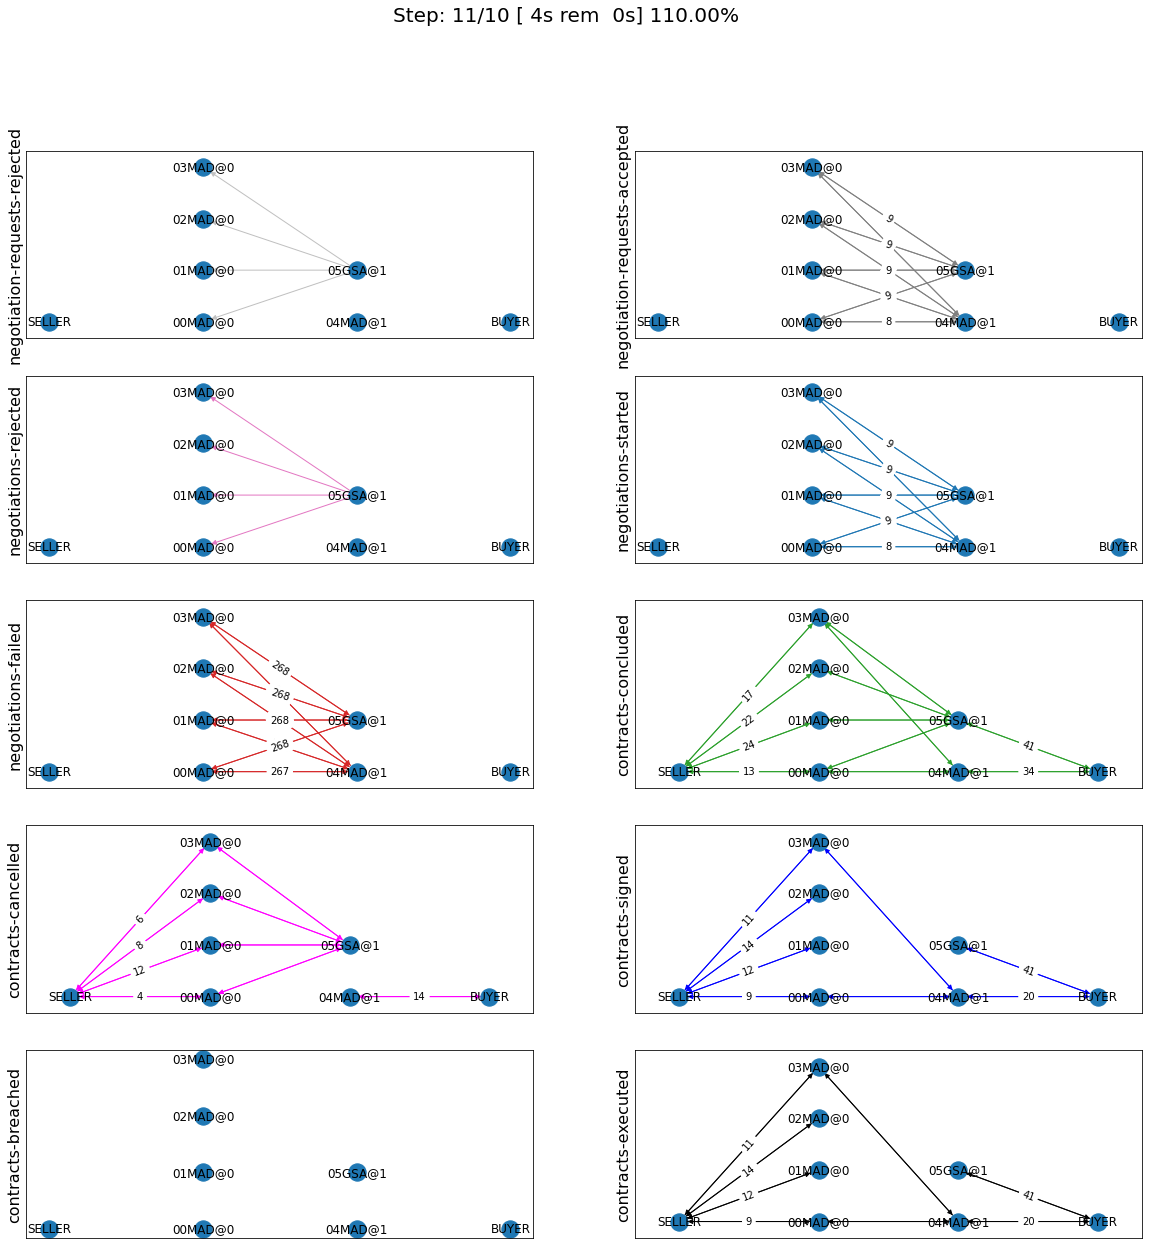

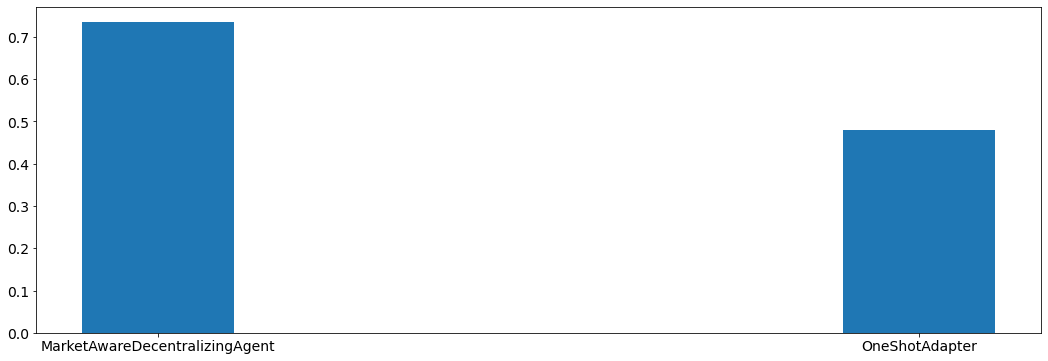

In [43]:
from scml.oneshot.agents import GreedySingleAgreementAgent

world = SCML2021World(
    **SCML2021World.generate([ComparisonAgent, GreedySingleAgreementAgent],
                             horizon=1, 
                             n_steps=10
                            ), 
    construct_graphs=True,
)
world.run_with_progress()

world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()
show_agent_scores(world)

This example shows that agents developed for the new OneShot track are interface-compatible with the `SCML2021World` (and `SCML2020World`) yet they usually reduce the trade in the whole market because they are not designed for the full SCML environment and use very restrictive assumptions. 

With that we end our tutorial. Have fun developing your agent.